**Full Name : El ghazi Loubna**

**Lab3 : Language Modeling / Regression AND Classification**

<h2>Language Modeling / Regression</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

**Dataset:https://github.com/dbbrandt/short_answer_granding_capstone_project/blob/master/data/
sag/answers.csv**

In [2]:
data = pd.read_csv(r'answers.csv')
print(data.head(5))

    id                                             answer  score  correct
0  1.1  High risk problems are address in the prototyp...    3.5      0.0
1  1.1  To simulate portions of the desired final prod...    5.0      1.0
2  1.1  A prototype program simulates the behaviors of...    4.0      1.0
3  1.1  Defined in the Specification phase a prototype...    5.0      1.0
4  1.1  It is used to let the users have a first idea ...    3.0      0.0


**Preprocessing NLP Pipeline:**

In [3]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [stemmer.stem(token) for token in tokens if token.isalnum() and token not in stop_words]
    return ' '.join(tokens)

data['processed_answer'] = data['answer'].apply(preprocess_text)

**Encoding Data Vectors:**

*Word2Vec:*

In [4]:
sentences = [word_tokenize(answer.lower()) for answer in data['answer']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)


*Bag of Words (BoW):*

In [5]:
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(data['processed_answer'])

*TF-IDF:*

In [6]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(data['processed_answer'])


**Training Models:**

*Support Vector Regression (SVR):*

In [7]:
y = data['score'] 
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


In [8]:
from sklearn.preprocessing import MaxAbsScaler


pipeline_svr = Pipeline([
    ('scaler', MaxAbsScaler()),  # Standardisation des caractéristiques
    ('svr', SVR())
])

param_grid_svr = {
    'svr__C': [1,10], #I tested too many values ...
    'svr__epsilon': [0.01, 0.1, 0.2, 0.5],
    'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svr__gamma': ['scale', 'auto']  # 'scale' (1 / (n_features * X.var())) ou 'auto' (1 / n_features)
}
grid_search_svr = GridSearchCV(estimator=pipeline_svr, param_grid=param_grid_svr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svr.fit(X_train, y_train)


best_svr_model = grid_search_svr.best_estimator_

y_pred_svr = best_svr_model.predict(X_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"Best hyperparametres : {grid_search_svr.best_params_}")
print(f"Model: SVR (Optimized)")
print(f"Mean Squared Error: {mse_svr}")
print(f"Root Mean Squared Error: {rmse_svr}")
print(f"R-squared: {r2_svr}")

Best hyperparametres : {'svr__C': 10, 'svr__epsilon': 0.01, 'svr__gamma': 'scale', 'svr__kernel': 'poly'}
Model: SVR (Optimized)
Mean Squared Error: 0.9684215620830615
Root Mean Squared Error: 0.9840841234788119
R-squared: 0.24285601534146817


*Linear Regression:*

In [9]:
# Train and evaluate Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Model: LinearRegression")
print(f"Mean Squared Error: {mse_lr}")
print(f"Root Mean Squared Error: {rmse_lr}")
print(f"R-squared: {r2_lr}")

Model: LinearRegression
Mean Squared Error: 2.7216842184893175
Root Mean Squared Error: 1.6497527749603325
R-squared: -1.1279026767399642


*Decision Tree:*

In [10]:
#la grille d'hyperparamètres (pour performer notre modele )
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

dt_model = DecisionTreeRegressor()

# Initialiser GridSearchCV 
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Entraîner le modèle avec les données d'entraînement
grid_search.fit(X_train, y_train)
##################################################
best_params = grid_search.best_params_
print(f"Best Hyperparametrs  : {best_params}")

# Utiliser le meilleur modèle pour prédire sur les données de test
best_dt_model = grid_search.best_estimator_
y_pred_dt = best_dt_model.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print(f"Model: Decision Tree (Optimized)")
print(f"Mean Squared Error: {mse_dt}")
print(f"Root Mean Squared Error: {rmse_dt}")
print(f"R-squared: {r2_dt}")


Best Hyperparametrs  : {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Model: Decision Tree (Optimized)
Mean Squared Error: 1.1469507858078662
Root Mean Squared Error: 1.0709578823688009
R-squared: 0.10327596764174607


C:\Users\LOUBNA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
225 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
225 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\LOUBNA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\LOUBNA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\LOUBNA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\

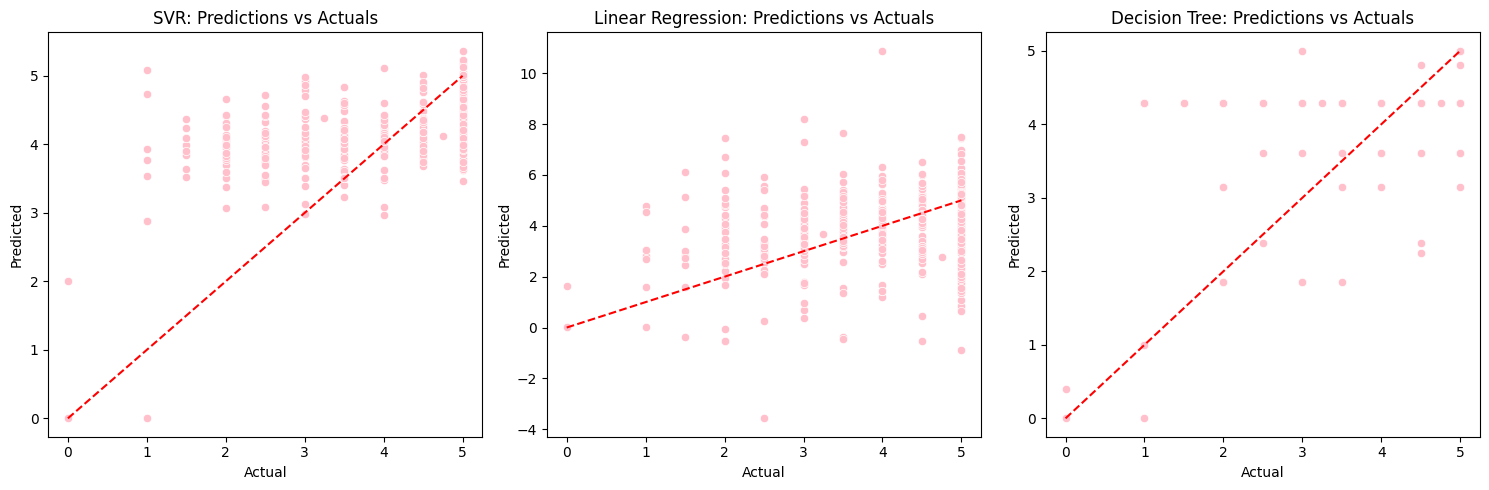

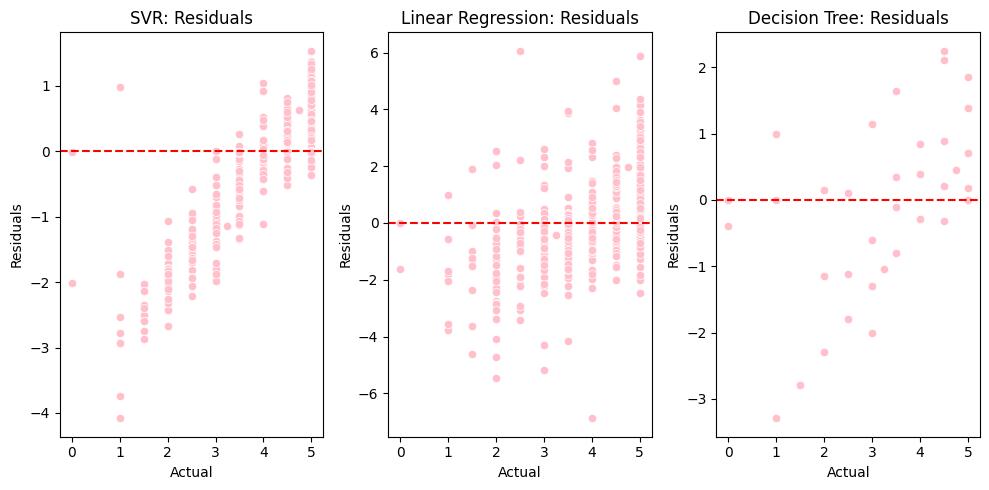

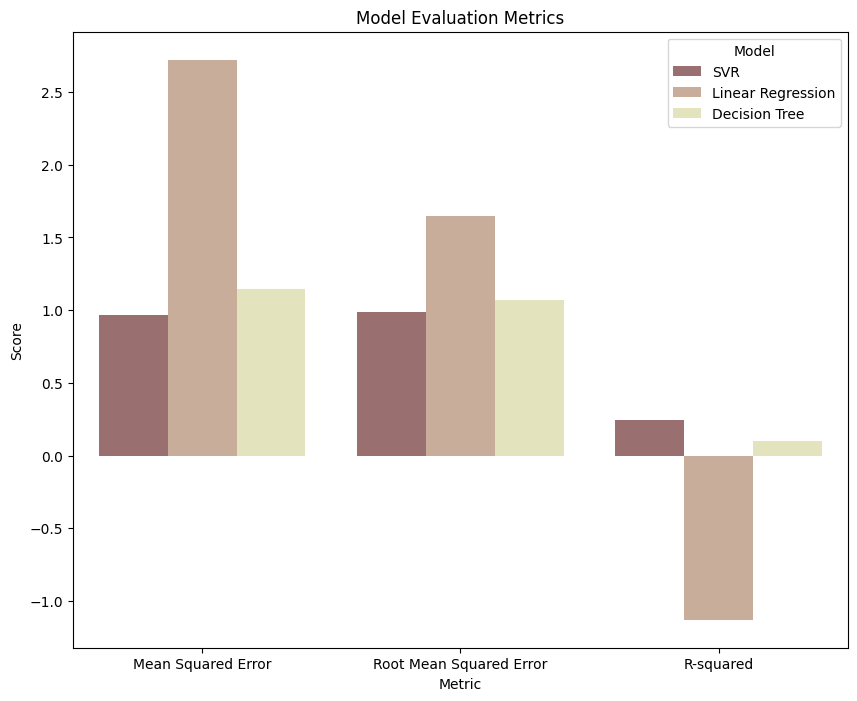

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))

# SVR
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_test, y=y_pred_svr, color='pink')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('SVR: Predictions vs Actuals')

# Linear Regression 
plt.subplot(1, 3, 2)
sns.scatterplot(x=y_test, y=y_pred_lr, color='pink')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression: Predictions vs Actuals')

# Decision Tree
plt.subplot(1, 3, 3)
sns.scatterplot(x=y_test, y=y_pred_dt, color='pink')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Decision Tree: Predictions vs Actuals')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))

# SVR residuals
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_test, y=y_test - y_pred_svr, color='pink')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('SVR: Residuals')

# Linear Regression residuals
plt.subplot(1, 3, 2)
sns.scatterplot(x=y_test, y=y_test - y_pred_lr, color='pink')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Linear Regression: Residuals')

# Decision Tree residuals
plt.subplot(1, 3, 3)
sns.scatterplot(x=y_test, y=y_test - y_pred_dt, color='pink')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Decision Tree: Residuals')

plt.tight_layout()
plt.show()

# Bar plot for evaluation metrics
metrics = ['Mean Squared Error', 'Root Mean Squared Error', 'R-squared']
values = [mse_svr, rmse_svr, r2_svr, mse_lr, rmse_lr, r2_lr, mse_dt, rmse_dt, r2_dt]
index = ['SVR', 'SVR', 'SVR', 'Linear Regression', 'Linear Regression', 'Linear Regression', 'Decision Tree', 'Decision Tree', 'Decision Tree']

metrics_df = pd.DataFrame({'Metric': metrics * 3, 'Value': values, 'Model': index})

plt.figure(figsize=(10, 8))
sns.barplot(x='Metric', y='Value', hue='Model', data=metrics_df, palette='pink')
plt.title('Model Evaluation Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.show()


**Part 2**

In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score

<h3>data : https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis?resource=download</h3>

In [3]:
train_df = pd.read_csv(r'twitter_training.csv', sep=',', names=['ID', 'Game', 'Sentiment', 'Text'])
val_df = pd.read_csv(r"twitter_validation.csv")

In [4]:
train_df.columns = ['ID', 'Entity', 'Sentiment', 'Text']
val_df.columns = ['ID', 'Entity', 'Sentiment', 'Text']

In [5]:
train_df.dropna(subset=['Text'], inplace=True)
val_df.dropna(subset=['Text'], inplace=True)


In [6]:
train_df.head()

,ID,Entity,Sentiment,Text
0,id,entity,sentiment,Tweet Content
1,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
2,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
3,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
4,2401,Borderlands,Positive,im coming on borderlands and i will murder you...


In [7]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove non-word characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    return text

def tokenize(text):
    return word_tokenize(text)

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens]

In [8]:
train_df['cleaned_text'] = train_df['Text'].apply(preprocess_text)
val_df['cleaned_text'] = val_df['Text'].apply(preprocess_text)
train_df['tokens'] = train_df['cleaned_text'].apply(tokenize)
val_df['tokens'] = val_df['cleaned_text'].apply(tokenize)


In [9]:
train_df['tokens'] = train_df['tokens'].apply(remove_stopwords)
val_df['tokens'] = val_df['tokens'].apply(remove_stopwords)
train_df['tokens'] = train_df['tokens'].apply(lemmatize)
val_df['tokens'] = val_df['tokens'].apply(lemmatize)

In [10]:
#ENCODINF THE DATA VECTORS 

word2vec_model = Word2Vec(sentences=train_df['tokens'], vector_size=100, window=5, min_count=1, sg=0)

def get_word_embedding(tokens, model):
    embeddings = []
    for word in tokens:
        if word in model.wv:
            embeddings.append(model.wv[word])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)  
# Apply word embeddings
train_word2vec = train_df['tokens'].apply(lambda x: get_word_embedding(x, word2vec_model))
val_word2vec = val_df['tokens'].apply(lambda x: get_word_embedding(x, word2vec_model))



In [11]:
#BAG OF WORDS
vectorizer = CountVectorizer()
train_bow = vectorizer.fit_transform(train_df['cleaned_text'])
val_bow = vectorizer.transform(val_df['cleaned_text'])
#TF-IDF
tfidf_vectorizer = TfidfVectorizer()
train_tfidf = tfidf_vectorizer.fit_transform(train_df['cleaned_text'])
val_tfidf = tfidf_vectorizer.transform(val_df['cleaned_text'])

In [12]:
#TRAINING
X_train = np.vstack(train_word2vec)
X_val = np.vstack(val_word2vec)
y_train = train_df['Sentiment'].values
y_val = val_df['Sentiment'].values

In [17]:
from sklearn.metrics import classification_report

In [24]:
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

NameError: name 'X_test' is not defined

In [26]:
svm_pred = svm.predict(X_val)
svm_accuracy = accuracy_score(y_val, svm_pred)
print("SVM Accuracy:", svm_accuracy)

SVM Accuracy: 0.5375375375375375


In [27]:
print("\nClassification Report for SVM:")
print(classification_report(y_val, svm_pred))


Classification Report for SVM:
              precision    recall  f1-score   support

  Irrelevant       0.40      0.12      0.19       171
    Negative       0.52      0.69      0.59       266
     Neutral       0.57      0.54      0.56       285
    Positive       0.55      0.64      0.59       277

    accuracy                           0.54       999
   macro avg       0.51      0.50      0.48       999
weighted avg       0.52      0.54      0.51       999



In [14]:
# Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(X_train, y_train)
naive_bayes_predictions = naive_bayes_classifier.predict(X_val)

In [15]:
naive_bayes_accuracy = accuracy_score(y_val, naive_bayes_predictions)
print("Naive Bayes Accuracy:", naive_bayes_accuracy)

Naive Bayes Accuracy: 0.4774774774774775


In [18]:
print("Classification Report for Naive Bayes:")
print(classification_report(y_val, naive_bayes_predictions))


Classification Report for Naive Bayes:
              precision    recall  f1-score   support

  Irrelevant       0.32      0.40      0.36       171
    Negative       0.51      0.61      0.56       266
     Neutral       0.53      0.46      0.49       285
    Positive       0.52      0.42      0.46       277

    accuracy                           0.48       999
   macro avg       0.47      0.47      0.47       999
weighted avg       0.49      0.48      0.48       999



In [19]:
logistic_regression_classifier = LogisticRegression(max_iter=1000)
logistic_regression_classifier.fit(X_train, y_train)
logistic_regression_predictions = logistic_regression_classifier.predict(X_val)

In [20]:
logistic_regression_accuracy = accuracy_score(y_val, logistic_regression_predictions)
print("Logistic Regression Accuracy:", logistic_regression_accuracy)

Logistic Regression Accuracy: 0.5275275275275275


In [21]:
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_val, logistic_regression_predictions))


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

  Irrelevant       0.37      0.11      0.17       171
    Negative       0.51      0.67      0.58       266
     Neutral       0.55      0.55      0.55       285
    Positive       0.55      0.63      0.58       277

    accuracy                           0.53       999
   macro avg       0.50      0.49      0.47       999
weighted avg       0.51      0.53      0.50       999



In [22]:
adaboost_classifier = AdaBoostClassifier(n_estimators=100)
adaboost_classifier.fit(X_train, y_train)
adaboost_predictions = adaboost_classifier.predict(X_val)

In [23]:
adaboost_accuracy = accuracy_score(y_val, adaboost_predictions)
print("AdaBoost Accuracy:", adaboost_accuracy)

AdaBoost Accuracy: 0.31931931931931934


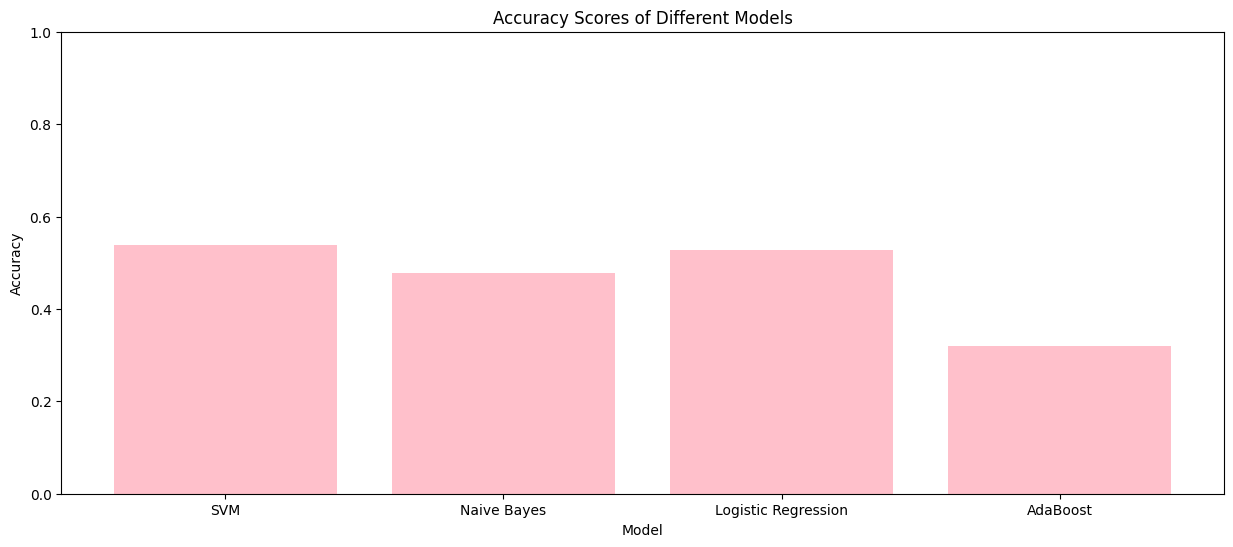

In [29]:
models = ['SVM', 'Naive Bayes', 'Logistic Regression', 'AdaBoost']
accuracies = [svm_accuracy, naive_bayes_accuracy, logistic_regression_accuracy, adaboost_accuracy]

# Plot
plt.figure(figsize=(15, 6))
plt.bar(models, accuracies, color='pink')
plt.title('Accuracy Scores of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limit to range between 0 and 1
plt.show()
